In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def generate_anchor_boxes(n, scales, ratios, w, h):
    """
    Generate anchor boxes for object detection.
    
    Args:
    n (int): Number of anchors to generate per scale and ratio.
    scales (list): List of scales for the anchor boxes.
    ratios (list): List of aspect ratios for the anchor boxes.
    w (int): Width of the image.
    h (int): Height of the image.
    
    Returns:
    numpy.ndarray: An array of shape (n * len(scales) * len(ratios), 4)
                   containing the anchor boxes in (x1, y1, x2, y2) format.
    """
    
    center_x = np.linspace(0, w, n + 1)[:-1] + w / (2 * n)
    center_y = np.linspace(0, h, n + 1)[:-1] + h / (2 * n)
    cx, cy = np.meshgrid(center_x, center_y)
    
    centers = np.vstack([cx.ravel(), cy.ravel()]).transpose()
    
    anchor_boxes = []
    
    for (c_x, c_y) in centers:
        for scale in scales:
            for ratio in ratios:
                half_w = scale * np.sqrt(ratio) / 2
                half_h = scale / np.sqrt(ratio) / 2
                
                x1 = max(c_x - half_w, 0)
                y1 = max(c_y - half_h, 0)
                x2 = min(c_x + half_w, w)
                y2 = min(c_y + half_h, h)
                
                anchor_boxes.append([x1, y1, x2, y2]) 
    anchor_boxes = np.array(anchor_boxes)
    return anchor_boxes

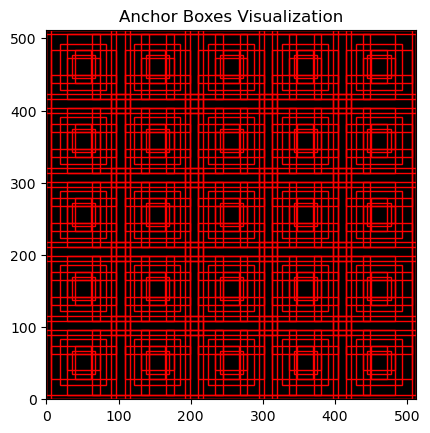

In [2]:
#test anchor boxes
n = 5
scales = [32, 64, 128]
ratios = [0.5, 1, 2]
w = 512
h = 512

anchor_boxes = generate_anchor_boxes(n, scales, ratios, w, h)
#print(anchor_boxes)
fig, ax = plt.subplots(1)
ax.set_xlim(0, w)
ax.set_ylim(0, h)
ax.set_aspect('equal', 'box')
ax.imshow(np.zeros((h, w, 3), dtype=np.uint8))  # Display a blank image

# Plot anchor boxes
for box in anchor_boxes:
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.title("Anchor Boxes Visualization")
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def IoU(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.

    Args:
    box1 (list or numpy.ndarray): Coordinates of the first bounding box in format [x1, y1, x2, y2].
    box2 (list or numpy.ndarray): Coordinates of the second bounding box in format [x1, y1, x2, y2].

    Returns:
    float: Intersection over Union (IoU) score.
    """
    # Coordinates of intersection rectangle
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Area of intersection rectangle
    intersection_area = max(0, x2_inter - x1_inter + 1) * max(0, y2_inter - y1_inter + 1)

    # Area of both bounding boxes
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou 

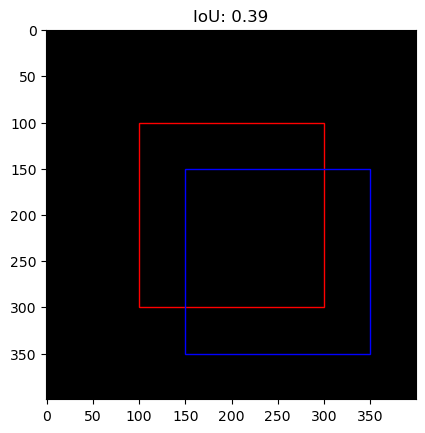

In [4]:
# Example usage
box1 = [100, 100, 300, 300]
box2 = [150, 150, 350, 350]

fig, ax = plt.subplots(1)
ax.imshow(np.zeros((400, 400, 3), dtype=np.uint8))  # Display a blank image

# Plot bounding boxes
rect1 = patches.Rectangle((box1[0], box1[1]), box1[2] - box1[0], box1[3] - box1[1], linewidth=1, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((box2[0], box2[1]), box2[2] - box2[0], box2[3] - box2[1], linewidth=1, edgecolor='b', facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)

# Calculate and display IoU
iou = IoU(box1, box2)
plt.title(f"IoU: {iou:.2f}")

plt.show()

In [5]:
def assign_anchor_boxes(y, anchor_boxes, lower_threshold=0.3, upper_threshold=0.5):
    """
    Assign each anchor box to a ground truth box.
    
    Args:
    y (numpy.ndarray): Ground truth bounding boxes of shape (n, 4).
    anchor_boxes (numpy.ndarray): Anchor boxes of shape (m, 4).
    lower_threshold (float): Lower threshold for IoU.
    upper_threshold (float): Upper threshold for IoU.

    Returns:
    numpy.ndarray: An array of shape (n, 1) containing the index of the assigned ground truth box for each anchor box.
    """
    
    m = anchor_boxes.shape[0]
    n = y.shape[0]
    
    iou_matrix = np.zeros((m, n))
    
    for i in range(m):
        for j in range(n):
            iou_matrix[i, j] = IoU(anchor_boxes[i], y[j])
    assigned_gt_idx = np.full(m, -1)
    iou_list = []
    for i in range(m):
        gt_idx = np.argmax(iou_matrix[i])
        iou = iou_matrix[i, gt_idx]
        iou_list.append(iou)
        if iou >= upper_threshold:
            assigned_gt_idx[i] = gt_idx
        elif iou < lower_threshold:
            assigned_gt_idx[i] = -1 # background
        else:
            assigned_gt_idx[i] = -2 # ignore
    print(max(iou_list))
    return assigned_gt_idx

0.6130040262003486


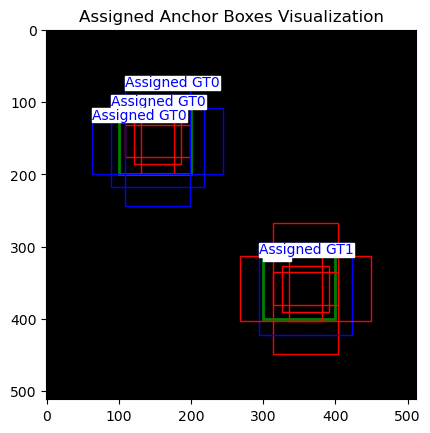

In [6]:
# Test usage and visualization
y = np.array([[100, 100, 200, 200], [300, 300, 400, 400]])
anchor_boxes = generate_anchor_boxes(5, [64, 128, 256, 384], [0.5, 1, 2], 512, 512)
assigned_gt_idx = assign_anchor_boxes(y, anchor_boxes)

# Visualize the assigned anchor boxes
def visualize_assigned_anchor_boxes(anchor_boxes, assigned_gt_idx, gt_boxes):
    fig, ax = plt.subplots(1)
    ax.imshow(np.zeros((512, 512, 3), dtype=np.uint8))  # Display a blank image

    # Plot ground truth boxes
    for i, box in enumerate(gt_boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1], f'GT{i}', color='g', verticalalignment='top', bbox={'color': 'white', 'pad': 0})

    # Plot assigned anchor boxes
    for i, idx in enumerate(assigned_gt_idx):
        if idx >= 0:
            rect = patches.Rectangle((anchor_boxes[i][0], anchor_boxes[i][1]), anchor_boxes[i][2] - anchor_boxes[i][0], anchor_boxes[i][3] - anchor_boxes[i][1], linewidth=1, edgecolor='b', facecolor='none')
            ax.add_patch(rect)
            ax.text(anchor_boxes[i][0], anchor_boxes[i][1], f'Assigned GT{idx}', color='b', verticalalignment='top', bbox={'color': 'white', 'pad': 0})
        # elif idx == -1:
        #     rect = patches.Rectangle((anchor_boxes[i][0], anchor_boxes[i][1]), anchor_boxes[i][2] - anchor_boxes[i][0], anchor_boxes[i][3] - anchor_boxes[i][1], linewidth=1, edgecolor='w', facecolor='none')
        #     ax.add_patch(rect)
        elif idx == -2:
            rect = patches.Rectangle((anchor_boxes[i][0], anchor_boxes[i][1]), anchor_boxes[i][2] - anchor_boxes[i][0], anchor_boxes[i][3] - anchor_boxes[i][1], linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    plt.title("Assigned Anchor Boxes Visualization")
    plt.show()

# Visualize assigned anchor boxes
visualize_assigned_anchor_boxes(anchor_boxes, assigned_gt_idx, y)

In [7]:
def calculate_offset(anchor_boxes, y, assigned_boxes):
    """
    Calculate the offset values for anchor boxes.

    Args:
    anchor_boxes (numpy.ndarray): Anchor boxes of shape (n, 4).
    y (numpy.ndarray): Ground truth bounding boxes of shape (n, 4).

    Returns:
    numpy.ndarray: Offset values for xyxy of shape (n, 4).
    """
    
    offsets = np.zeros_like(anchor_boxes)

    for i, box in enumerate(anchor_boxes):
        if assigned_boxes[i] >= 0:
            gt_box = y[assigned_boxes[i]]
            offsets[i] = [(gt_box[0] - box[0]) / (box[2] - box[0]),
                          (gt_box[1] - box[1]) / (box[3] - box[1]),
                          (gt_box[2] - box[2]) / (box[2] - box[0]),
                          (gt_box[3] - box[3]) / (box[3] - box[1])]
    return offsets

0.6130040262003486
Anchor Box 75: [-0.09220193  0.20389904  0.01265242 -0.24367379]
Anchor Box 76: [ 0.08125  0.08125 -0.1375  -0.1375 ]
Anchor Box 77: [ 0.20389904 -0.09220193 -0.24367379  0.01265242]
Anchor Box 220: [ 0.04375  0.04375 -0.175   -0.175  ]


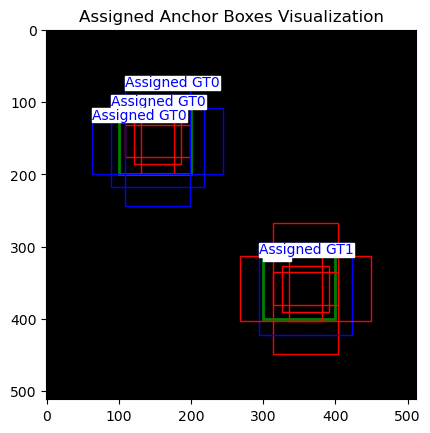

In [8]:
# Test usage
anchor_boxes = generate_anchor_boxes(5, [64, 128, 256, 384], [0.5, 1, 2], 512, 512)
y = np.array([[100, 100, 200, 200], [300, 300, 400, 400]])
assigned_boxes = assign_anchor_boxes(y, anchor_boxes)

offsets = calculate_offset(anchor_boxes, y, assigned_boxes)
for i, offset in enumerate(offsets):
    if assigned_boxes[i] >= 0:
        print(f"Anchor Box {i}: {offset}")

visualize_assigned_anchor_boxes(anchor_boxes, assigned_boxes, y)

In [58]:
def assign_class_label(anchor_boxes, assigned_boxes, true_labels):
    """
    Assign class labels to anchor boxes.

    Args:
    anchor_boxes (numpy.ndarray): Anchor boxes of shape (n, 4).
    assigned_boxes (numpy.ndarray): Index of the assigned ground truth box for each anchor box.
    true_labels (numpy.ndarray): true labels for each ground truth box.

    Returns:
    numpy.ndarray: Class labels for each anchor box.
    """

    class_labels = np.full(anchor_boxes.shape[0], -1)
    for i, idx in enumerate(assigned_boxes):
        if idx >= 0:
            class_labels[i] = true_labels[idx]
        elif idx == -1:
            class_labels[i] = -1
        else:
            class_labels[i] = -2
    return class_labels


In [60]:
# Test usage
true_labels = np.array([0, 1])
class_labels = assign_class_label(anchor_boxes, assigned_boxes, true_labels)
for i, label in enumerate(class_labels):
    if assigned_boxes[i] >= 0:
        print(f"Anchor Box {i}: Class {label}")

Anchor Box 75: Class 0
Anchor Box 76: Class 0
Anchor Box 77: Class 0
Anchor Box 220: Class 1


In [48]:
def inverse_offset(offsets, anchor_boxes):
    """
    Calculate the corrected boxes given the predicted offsets.
    Args:
        offsets (numpy.ndarray): Array of predicted offsets.
        anchor_boxes (numpy.ndarray): Array of anchor boxes.
    
    Returns:
        numpy.ndarray: Array of corrected boxes.
    """
    predicted_boxes = np.zeros_like(anchor_boxes)
    
    for i, box in enumerate(anchor_boxes):
        if offsets[i].any():
            offset = offsets[i]
            predicted_boxes[i] = [box[0] + offset[0] * (box[2] - box[0]),
                                  box[1] + offset[1] * (box[3] - box[1]),
                                  box[2] + offset[2] * (box[2] - box[0]),
                                  box[3] + offset[3] * (box[3] - box[1])]
        else:
            predicted_boxes[i] = box
        
    return predicted_boxes
    

In [49]:
# Test usage
anchor_boxes = generate_anchor_boxes(5, [64, 128, 256, 384], [0.5, 1, 2], 512, 512)
y = np.array([[100, 100, 200, 200], [300, 300, 400, 400]])
assigned_boxes = assign_anchor_boxes(y, anchor_boxes)
offsets = calculate_offset(anchor_boxes, y, assigned_boxes)
predicted_boxes = inverse_offset(offsets, anchor_boxes)

0.6130040262003486


In [50]:
def visualize_corrected_anchor_boxes(corrected_anchor_boxes):
    fig, ax = plt.subplots(1)
    ax.imshow(np.zeros((512, 512, 3), dtype=np.uint8))  # Display a blank image

    # Plot corrected anchor boxes
    for i, box in enumerate(corrected_anchor_boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1], f'', color='b', verticalalignment='top', bbox={'color': 'white', 'pad': 0})

    plt.title("Corrected Anchor Boxes Visualization")
    plt.show()


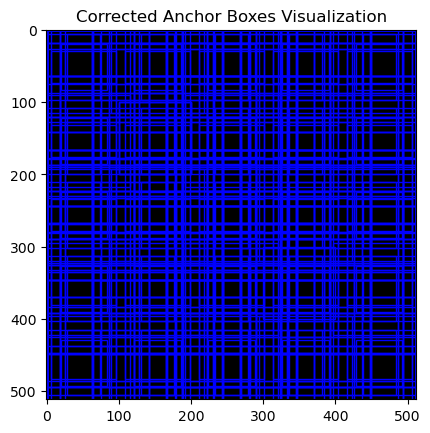

In [51]:
# test usage of corrected anchor boxes
visualize_corrected_anchor_boxes(predicted_boxes)